# Importing

First, I imported the requred packages. Requests and JSON were necessary for loading data from the US Census API, pandas was necessary for data cleaning/transformation, and Pyplot, Altair, and Seaborn were used for plotting information.

In [1]:
import requests
import json

import pandas as pd

import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

# 1: Do veterans employ more workers? Does this differ between states?

First, we make an API call to census.gov, and build the query programatically, looking for employee counts from each state, grouped by the owner's status as a veteran. We then load the data from the query into a pandas DataFrame, using the `col_names` list for the column names.

In [2]:
HOST = 'https://api.census.gov/data'
year = '2018'
dataset = 'abscs'

base_url = '/'.join([HOST, year, dataset])

predicates = {}

get_vars = ["NAME", "VET_GROUP", "EMP"]

predicates['get'] = ','.join(get_vars)

predicates['for'] = 'state:*'

r = requests.get(base_url, params = predicates)

col_names = ['State', 'Veteran status', 'Number employed', 'State code'] #Same order as request

df = pd.DataFrame(columns = col_names, data = r.json()[1:])

Next, we convert the number of employees from string objects to integers.

In [3]:
df['Number employed'] = df['Number employed'].astype(int)

We create a new DataFrame to hold the description of each veteran status, linked to the code as it exists in the census data.

In [4]:
col_names = ['Veteran status', 'Description']
codes = [['001', 'Total'],
        ['002', 'Veteran'],
        ['003', 'Equal'],
        ['004', 'Nonveteran']]

vetcodes = pd.DataFrame(columns = col_names, data = codes)

Finally, we merge the DataFrame of census information with the veteran code descriptions, linking them together by the numeric veteran status.

In [5]:
df = df.merge(vetcodes, how = 'inner', on = 'Veteran status')

I chose to drill down, and compare the states Minnesota and Texas to answer the question. We create two new DataFrames, filtering the data down to Minnesota and Texas respectively.

In [6]:
mndf = df[df.State == 'Minnesota']
txdf = df[df.State == 'Texas']

Because of the difference in population, we need to display the proportions of each employee count, rather than the literal count. We divide each round by the total employee count, then multiply it by 100.

Running this command throws a warning, but should complete without issue.

In [7]:
mndf['Number employed'] = (100. * mndf['Number employed'] / mndf['Number employed'].sum()).round(0)
txdf['Number employed'] = (100. * txdf['Number employed'] / txdf['Number employed'].sum()).round(0)

C:\Users\CHRIST~1\AppData\Local\Temp/ipykernel_16600/3687439341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mndf['Number employed'] = (100. * mndf['Number employed'] / mndf['Number employed'].sum()).round(0)
C:\Users\CHRIST~1\AppData\Local\Temp/ipykernel_16600/3687439341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  txdf['Number employed'] = (100. * txdf['Number employed'] / txdf['Number employed'].sum()).round(0)


We now simply create a list of these DataFrames and concatenate the list using `pd.concat`.

In [8]:
statelist = [mndf, txdf]
statedf = pd.concat(statelist)

We can now create our visualization.

First, we create a FacetGrid to hold the information, separated by the value in the `State` column.

Then, we create a Seaborn barplot in each facet, showing `Number employed` split up by `Description`, which is the veteran code. 

Finally, we set our axis labels and our title, and display the plot.

Text(0.5, 0.98, 'Number Employed by Veteran Ownership Status')

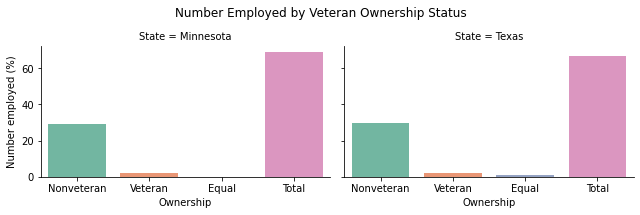

In [9]:
g = sns.FacetGrid(statedf, col="State", aspect = 1.5)
g.map_dataframe(sns.barplot, x="Description", y = "Number employed", palette = 'Set2')
g.set_axis_labels(x_var = 'Ownership', y_var = 'Number employed (%)')

g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Number Employed by Veteran Ownership Status')

# 2: Do veteran-owned businesses pay their employees more? 

Similarly to the first process, we begin with our API call, then construct our pandas DataFrame containing `Annual Payroll`, the total amount of money paid out by employers in the survey, along with the `Number Employed` and `State` from the previous process. We convert the `Number Employed` and `Annual Payroll` to integers as well.

In [10]:
HOST = 'https://api.census.gov/data'
year = '2018'
dataset = 'abscs'

base_url = '/'.join([HOST, year, dataset])

predicates = {}

get_vars = ["NAME", "VET_GROUP", "PAYANN", "EMP"]

predicates['get'] = ','.join(get_vars)

predicates['for'] = 'state:*'

r = requests.get(base_url, params = predicates)

col_names = ['State', 'Veteran status', 'Annual Payroll', 'Number employed', 'State code'] #Same order as request

df = pd.DataFrame(columns = col_names, data = r.json()[1:])

df['Number employed'] = df['Number employed'].astype(int)
df['Annual Payroll'] = df['Annual Payroll'].astype(int)

Once again, we merge the main DataFrame with the `vetcodes` DataFrame.

In [11]:
df2 = df.merge(vetcodes, how = 'inner', on = 'Veteran status')

This time, we use Altair to create our graph in four steps. Each step s

First, we create the base chart, a `mark_point` scatter plot comparing `Number employed` to `Annual Payroll`, with each point representing one state's data from each veteran code, colored based on the veteran code. (Altair also allows us to add a tooltip on each point, listing the state name.

Second, the then add a `mark_line` regression line through the data. We use the `transform_regression` method, which creates a regression equation that the `mark_line` will draw.

Third, we take advantage of the `params` parameter in the `transform_regression` method, which returns the equation's coefficients and the r-Squared value. `transform_calculate` allows us to extract the intercept and slope. Finally, we store each in a `mark_text` element to display on the chart.

Finally, we can use Altair to simply layer the charts one on top of the other. 

In [12]:
base = alt.Chart(df2[df2['Veteran status'] != '001']).mark_point().encode(
    x='Number employed',
    y='Annual Payroll',
    color = 'Description',
    tooltip = 'State'
).properties(title = 'Annual Payroll vs. # Employed by Veteran Status')

reg = base.transform_regression('Number employed', 'Annual Payroll').mark_line().encode()

params1 = alt.Chart(df2[df2['Veteran status'] != '001']).transform_regression(
    'Number employed', 'Annual Payroll', params=True
).transform_calculate(
    intercept='datum.coef[0]',
    slope='datum.coef[1]',
).mark_text(align='left').encode(
    x=alt.value(200),  # pixels from left
    y=alt.value(60),  # pixels from top
    text='slope:N'
)

params2 = alt.Chart(df2[df2['Veteran status'] != '001']).transform_regression(
    'Number employed', 'Annual Payroll', params=True
).mark_text(align='left').encode(
    x=alt.value(20),  # pixels from left
    y=alt.value(20),  # pixels from top
    text='rSquared:N'
)

base + reg + params1 + params2

alt.LayerChart(...)

# 3 - How many employees does the average employer employ in each state?

This time, we will need to merge data from two separate tables, but the process is still the same - API call, DataFrame, type conversion. From the Characteristics of Businesses API, we get the employee count by state (which we convert to an integer), and from the Characteristics of Business Owners API, we get the employer count by state (which we also convert to an integer). 

In [13]:
HOST = 'https://api.census.gov/data'
year = '2018'
dataset = 'abscb'
                            
base_url = '/'.join([HOST, year, dataset])

predicates = {}

get_vars = ["NAME", "EMP"]

predicates['get'] = ','.join(get_vars)

predicates['for'] = 'state:*'

r = requests.get(base_url, params = predicates)

col_names = ['State', 'Number employed','State code'] #Same order as request

empdf = pd.DataFrame(columns = col_names, data = r.json()[1:])

empdf['Number employed'] = empdf['Number employed'].astype(int)

In [14]:
HOST = 'https://api.census.gov/data'
year = '2018'
dataset = 'abscbo'

base_url = '/'.join([HOST, year, dataset])

predicates = {}

get_vars = ["NAME", "OWNPDEMP"]

predicates['get'] = ','.join(get_vars)

predicates['for'] = 'state:*'

r = requests.get(base_url, params = predicates)

col_names = ['State', 'Number of owners', 'State code'] #Same order as request

owndf = pd.DataFrame(columns = col_names, data = r.json()[1:])

owndf['Number of owners'] = owndf['Number of owners'].astype(int)

We then merge these two DataFrames on the State column, which we can do because each DataFrame is of the same length.

In [15]:
perdf = owndf.merge(empdf, how = "inner", on = 'State')

We now drop the unnecessary `State code` columns from the DataFrame.

In [16]:
perdf = perdf.drop(['State code_x', 'State code_y'], axis = 1)

Finally, we create a new column by dividing each state's number of employees by the number of owners, resulting in the number of employees per employer in each state. 

In [17]:
perdf['Employees per Employer'] = perdf['Number employed'] / perdf['Number of owners']

 Now, we can create a Seaborn `mark_bar` histogram plot of the data. We also add a `mark_rule` indicating the data's mean. 

In [18]:
base = alt.Chart(perdf)

bar = base.mark_bar().encode(
    x=alt.X('Employees per Employer', bin=True),
    y=alt.Y('count()', title = "Number of States")
)

rule = base.mark_rule(color='red', opacity = 0.9).encode(
    x= alt.X('mean(Employees per Employer)', title = "Employees per Employer"),
    size=alt.value(5)
)

(bar + rule).properties(
    title = 'Average number of Employees per Company Owner in the US'
).configure_mark(
    color = "darkblue"
)

alt.LayerChart(...)